In [5]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sklearn
from sklearn import preprocessing

import math
import argparse
import torch
import torch.utils.tensorboard
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.nn.utils import clip_grad_norm_
from tqdm.auto import tqdm

from utils.misc import *
from utils.utils_score import *

from dataset.load_data_generated import *
from models.vae_gaussian import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import glob
from models.refiner import Refiner
ckpt_file = glob.glob('graph_diffusion_refinement/n87qbyim/checkpoints/epoch*.ckpt')[0]
model_denoise = Refiner.load_from_checkpoint(ckpt_file)
args = model_denoise.hparams
model_denoise = model_denoise.generator.to('cuda')

In [7]:
from models.transformer import Transformer

# model_id = args.diffusion_model
# model = Transformer.load_from_checkpoint(f'./graph_diffusion_perceptron/{model_id}/checkpoints/last.ckpt')
diffusion_model_path = glob.glob(f'graph_diffusion_perceptron/{args.diffusion_model}/checkpoints/epoch*.ckpt')[0]
model = Transformer.load_from_checkpoint(diffusion_model_path)
model.eval()
pass

In [8]:
datasetname=model.hparams.dataset
point_dimns = model.hparams.k

train_set = LaplacianDatasetNX(datasetname,'data/'+datasetname,point_dim=model.hparams.k, smallest=model.hparams.smallest, split='train')
test_set = LaplacianDatasetNX(datasetname,'data/'+datasetname,point_dim=model.hparams.k, smallest=model.hparams.smallest, split='test')

Point dim 32
Comp dimensions...
Comp stats...
Loaded precomuted eigenquantities
Comp Samples...
Tot #200
Point dim 32
Comp dimensions...
Comp stats...
Loaded precomuted eigenquantities
Comp Samples...
Tot #200


In [5]:
train_set.degree

0.00015084361440065308

In [9]:
# model_denoise = torch.load(f'data/{datasetname}_{point_dimns}{args.smallest}.model')
# model_denoise = torch.load('./data/'+datasetname+'_generator.torch')
# model_denoise.to('cuda')
pass

# model_denoise = torch.load('./data/'+args.dataset+'_generator.torch')
# discriminator = torch.load('./data/'+args.dataset+'_discriminator.torch')

In [10]:
# Reference Point Clouds
model.eval()
model.to('cuda')

n,k = train_set[0][0].shape
n_graphs = len(test_set)*1
n_nodes = list(train_set.sample_n_nodes(n_graphs-1)) + [train_set.n_max]

# Generate Point Clouds
gen_pcs = []
for i in tqdm(range(0, 1), 'Generate'):
    with torch.no_grad():
#         z = torch.randn([args.batch_size, ckpt['args'].latent_dim]).to(args.device)
        x = model.sample(n_nodes, n_graphs, 1, point_dim=k, scale_xy=train_set.scale_xy, unscale_xy=train_set.unscale_xy)
        print(x.shape)
        gen_pcs.append(x.detach().cpu())
gen_pcs_l = torch.cat(gen_pcs, dim=0)#[:len(test_dset)]
# if args.normalize is not None:
#     gen_pcs = normalize_point_clouds(gen_pcs_l[...,:3], mode=args.normalize, logger=logger)
samples_EIGVEC = gen_pcs_l[...,:]


Generate:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([40, 65, 32])


Generate: 100%|██████████| 1/1 [02:31<00:00, 151.63s/it]


In [61]:
# import time
# t0 = time.time()
# for i in range(3):
#     with torch.no_grad():
#         x = model.sample(n_nodes[:10], n_graphs, 1, point_dim=k, scale_xy=train_set.scale_xy, unscale_xy=train_set.unscale_xy)
#         xx = x[:,:-1,:]
#         yy = x[:,-1,:]
#         mask = xx.abs().sum(-1)>1e-6
# #         xx,yy = train_set.unscale_xy(xx,yy)

#         inno =  torch.randn(list(mask.shape[:2])+[model_denoise.latent_dim], device=x.device)*1e-2
#         _ = model_denoise(inno, yy, xx, mask).cpu()
    
# print((time.time()-t0)/3)        
    

0.5420416990915934


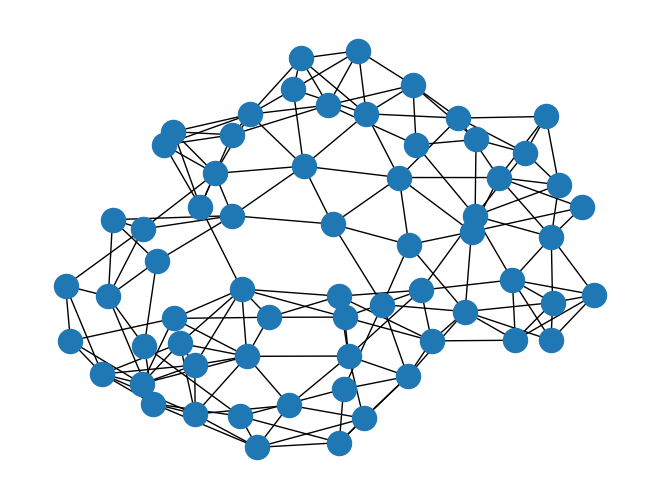

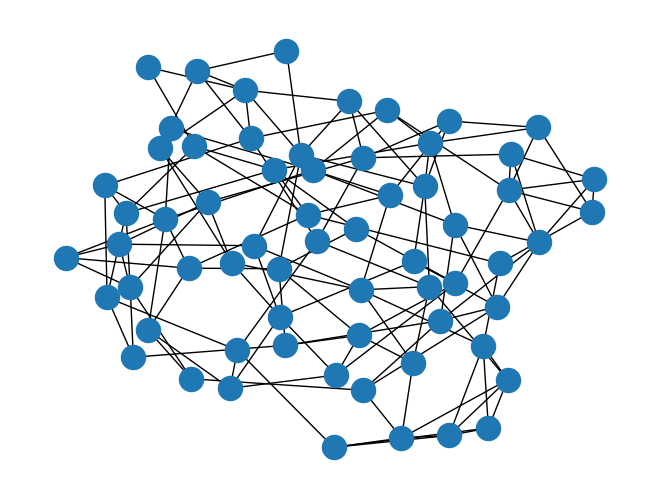

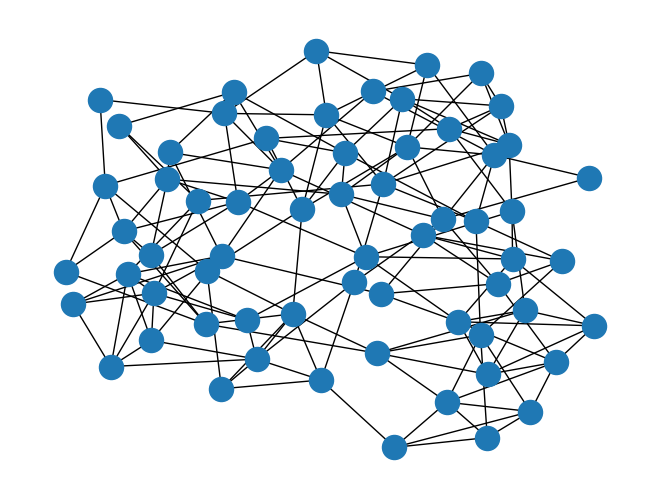

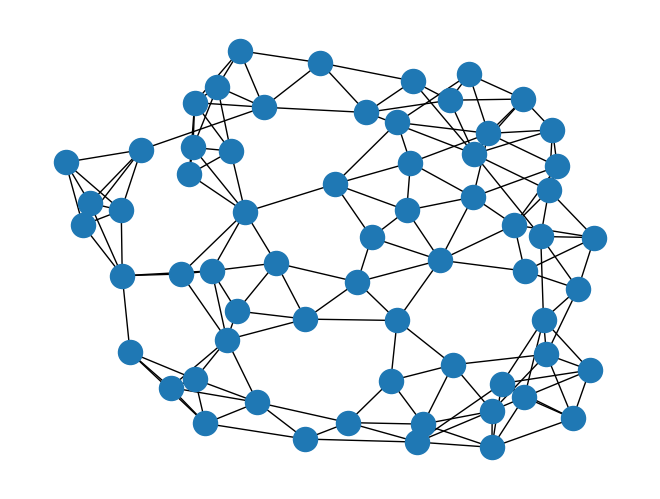

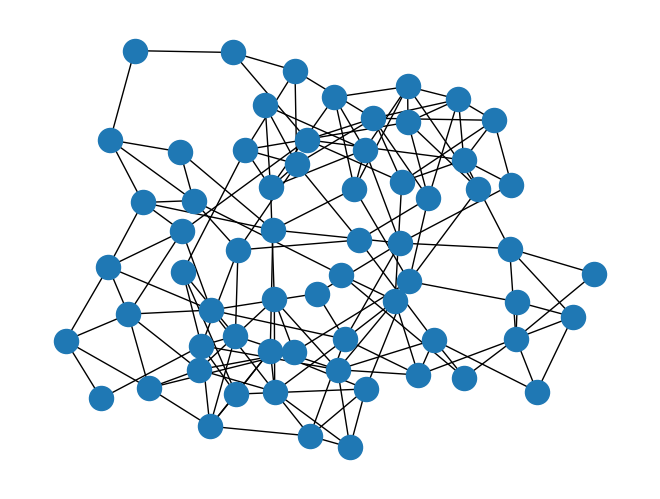

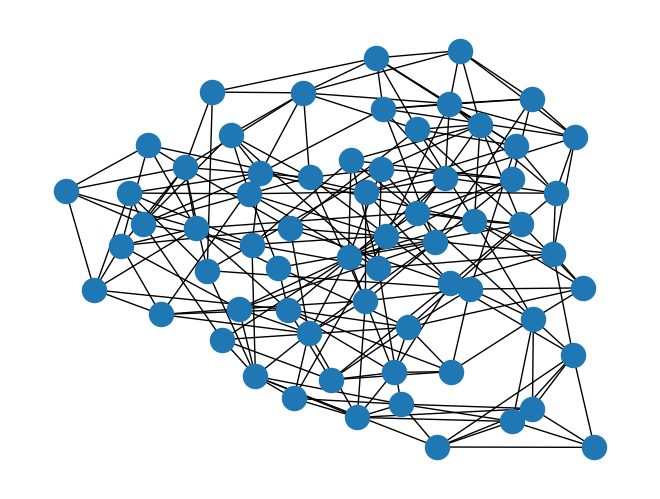

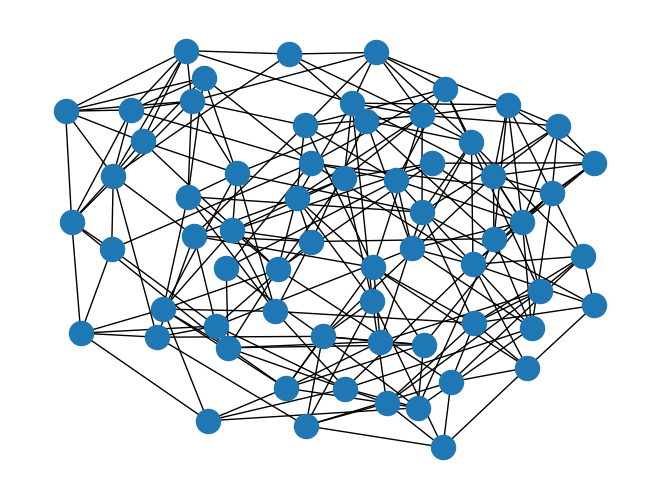

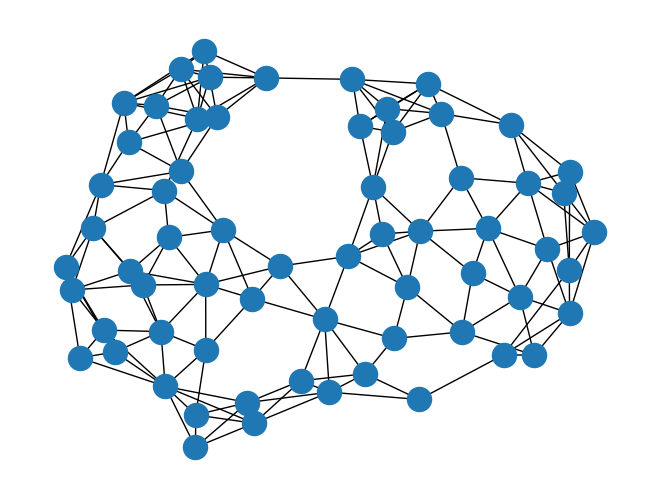

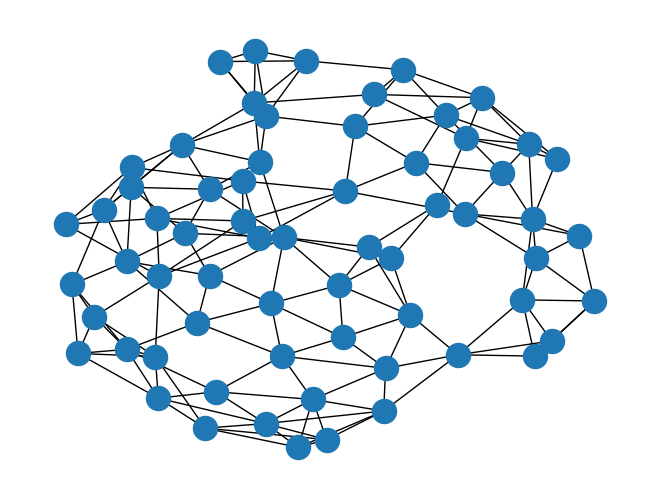

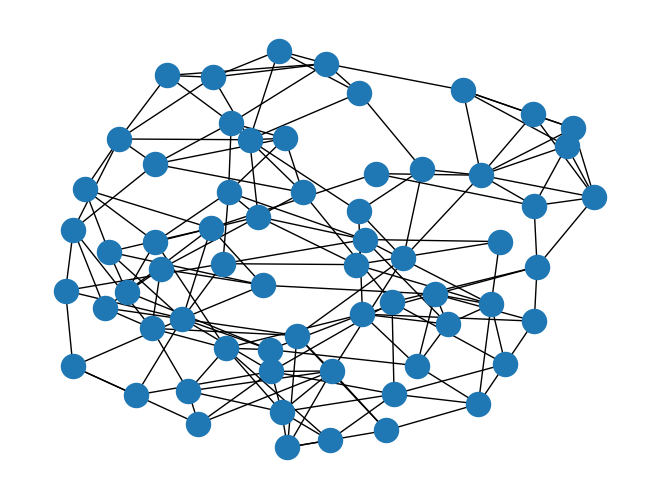

In [11]:
# samples_EIGVEC[:,:-1,:].abs().sum(-1).shape
# samples_EIGVEC[:,:,:] = samples_EIGVEC[:1,:,:]
gen_dev = 'cuda'

xx = samples_EIGVEC[:,:-1,:].to(gen_dev)
yy = samples_EIGVEC[:,-1,:].to(gen_dev)
mask = xx.abs().sum(-1)>1e-6

xx,yy = train_set.unscale_xy(xx,yy)
# xx = xx/xx.norm(dim=1)[:,None,:]

with torch.no_grad():
#     mask = torch.ones(1,xx.shape[1],xx.shape[1]).expand(xx.shape[0],xx.shape[1]).to(gen_dev)
    inno =  torch.randn(list(mask.shape[:2])+[model_denoise.latent_dim], device=gen_dev)*1e-2
    fake_adj = model_denoise(inno, yy, xx, mask).cpu()
    
    
import scipy
LLLall_ =[]

di=0
graph_pred_list = []
for i, A in enumerate(fake_adj.cpu()):
    A = (A>0.5).float()
    mask = A.sum(-1)>0
    G = nx.Graph(A[mask,:][:,mask].numpy())
    graph_pred_list.append(G)


#display
for A in graph_pred_list[:10]:
    nx.draw_kamada_kawai(A)
    plt.show()
        

    

In [7]:
test_set.get_extra_data()
train_set.get_extra_data()

#compute metrics
graph_test_list = [] #should be on test set graphs
for jj in range(len(test_set)):
    laplacian_matrix = np.array(test_set[jj][3].cpu())[:test_set[jj][4],:test_set[jj][4]]
    Aori = np.copy(laplacian_matrix)
    np.fill_diagonal(Aori,0)
    Aori= Aori*(-1)
    graph_test_list.append(nx.from_numpy_array(Aori)) 

graph_train_list = []
for jj in range(len(train_set)):
    laplacian_matrix = np.array(train_set[jj][3].cpu())[:train_set[jj][4],:train_set[jj][4]]
    Aori = np.copy(laplacian_matrix)
    np.fill_diagonal(Aori,0)
    Aori= Aori*(-1)
    graph_train_list.append(nx.from_numpy_array(Aori)) 

graph_pred_list_remove_empty = [G for G in graph_pred_list if not G.number_of_nodes() == 0]#[:len(test_set)]

degree, cluster, orbit, unique, novel, spectral = 0,0,0,0,0,0
if len(graph_pred_list_remove_empty)>0:
    degree = degree_stats( graph_test_list,graph_pred_list_remove_empty, compute_emd=False)
    cluster = clustering_stats( graph_test_list,graph_pred_list_remove_empty, compute_emd=False)
    orbit = orbit_stats_all(graph_test_list, graph_pred_list_remove_empty, compute_emd=False)
    unique,novel,_ = eval_fraction_unique_non_isomorphic_valid(graph_pred_list_remove_empty,graph_train_list)
    spectral = spectral_stats(graph_test_list, graph_pred_list_remove_empty)

for m in degree, cluster, orbit, unique, novel, spectral:
    print(m)
    
for m_t,m in zip( [train_set.degree, train_set.cluster,  train_set.spectral],[degree, cluster,  spectral]):
    print(m_t, '\t', m/m_t)

NameError: name 'graph_pred_list' is not defined